In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [2]:
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet_224_c',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [10]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.762002,0.608299,0.715385,0.734637,0.674359,0.703209,0.778593,01:38


Better model found at epoch 0 with f1_score value: 0.7032085561497325.


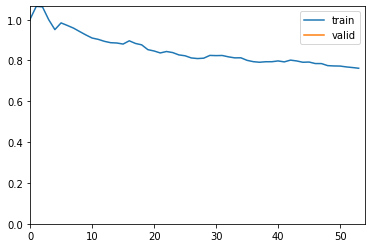

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.540278,0.285551,0.758974,0.795322,0.697436,0.743169,0.839563,01:47
1,0.469716,0.241081,0.800000,0.854545,0.723077,0.783333,0.870888,01:45
2,0.433275,0.218485,0.788462,0.833828,0.720513,0.773040,0.880769,01:42
3,0.391097,0.174204,0.806410,0.852507,0.741026,0.792867,0.895927,01:47
4,0.354607,0.170699,0.794872,0.809140,0.771795,0.790026,0.885299,01:48
5,0.320646,0.161048,0.817949,0.873494,0.743590,0.803324,0.905076,01:48
6,0.294335,0.155075,0.803846,0.822888,0.774359,0.797886,0.889977,01:49
7,0.261627,0.126275,0.814103,0.851003,0.761538,0.803789,0.906953,01:49
8,0.236913,0.124806,0.817949,0.848315,0.774359,0.809651,0.912426,01:49
9,0.219632,0.115412,0.825641,0.864943,0.771795,0.815718,0.905141,01:48


Better model found at epoch 0 with f1_score value: 0.7431693989071038.


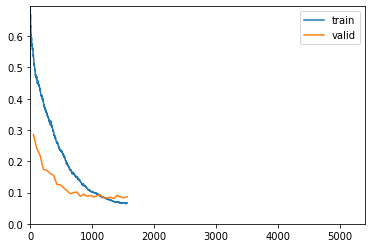

Better model found at epoch 1 with f1_score value: 0.7833333333333332.
Better model found at epoch 3 with f1_score value: 0.7928669410150893.
Better model found at epoch 5 with f1_score value: 0.8033240997229917.
Better model found at epoch 7 with f1_score value: 0.8037889039242219.
Better model found at epoch 8 with f1_score value: 0.8096514745308311.
Better model found at epoch 9 with f1_score value: 0.8157181571815718.
Better model found at epoch 10 with f1_score value: 0.825268817204301.
Better model found at epoch 11 with f1_score value: 0.8337874659400544.
Better model found at epoch 18 with f1_score value: 0.8373333333333333.
Better model found at epoch 19 with f1_score value: 0.8515111695137977.
Better model found at epoch 22 with f1_score value: 0.8586387434554973.
Better model found at epoch 23 with f1_score value: 0.8710089399744574.
No improvement since epoch 24: early stopping


In [11]:
learn.fine_tune(100,base_lr=1e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9614106508875738.


(#6) [0.0736546516418457,0.9005128145217896,0.9149840595111584,0.8830769230769231,0.8987473903966596,0.9614106508875738]

# 384

In [18]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet50_384_c',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [21]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [22]:
learn.load('resnet_224_c')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0002290867705596611)

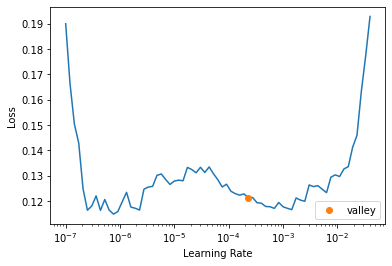

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.139962,0.112070,0.821795,0.890966,0.733333,0.804501,0.914241,02:04


Better model found at epoch 0 with f1_score value: 0.8045007032348803.


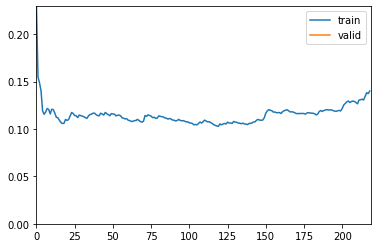

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.099323,0.089000,0.870513,0.900277,0.833333,0.865513,0.936456,02:15
1,0.097607,0.085978,0.861538,0.898305,0.815385,0.854839,0.942617,02:15
2,0.097365,0.094279,0.857692,0.904348,0.800000,0.848980,0.938879,02:15
3,0.087900,0.082773,0.860256,0.904899,0.805128,0.852103,0.946660,02:15
4,0.081987,0.084710,0.870513,0.902507,0.830769,0.865154,0.938609,02:14
5,0.076521,0.081743,0.874359,0.892473,0.851282,0.871391,0.947771,02:15
6,0.082469,0.084569,0.865385,0.840095,0.902564,0.870210,0.948419,02:15
7,0.076894,0.088662,0.861538,0.885246,0.830769,0.857143,0.937975,02:15
8,0.082913,0.083835,0.870513,0.916427,0.815385,0.862958,0.950736,02:15
9,0.080916,0.080276,0.853846,0.877049,0.823077,0.849206,0.944885,02:15


Better model found at epoch 0 with f1_score value: 0.8655126498002662.


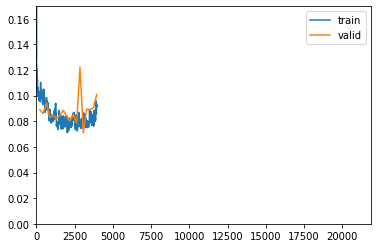

Better model found at epoch 5 with f1_score value: 0.8713910761154856.
Better model found at epoch 11 with f1_score value: 0.8732026143790849.
Better model found at epoch 13 with f1_score value: 0.881578947368421.
Better model found at epoch 18 with f1_score value: 0.8844621513944224.
No improvement since epoch 13: early stopping


In [24]:
learn.fine_tune(100,base_lr=3e-3)

In [25]:
dfTest = pd.read_csv('../testSample.csv')

In [26]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [27]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [28]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [29]:
learn.dls = dlsTest

In [30]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9611939513477975.


(#6) [0.08134358376264572,0.9056410193443298,0.9360529217199559,0.8707692307692307,0.9022316684378321,0.9611939513477975]

# 512

In [31]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet50_512_c',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [32]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [33]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [34]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [35]:
learn.load('resnet50_384_c')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=4.786300905834651e-06)

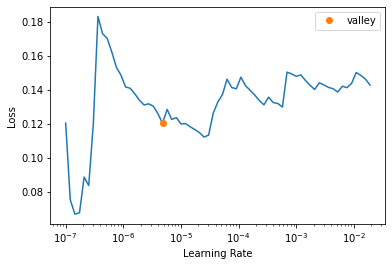

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.185298,0.118845,0.862821,0.826790,0.917949,0.869988,0.936907,03:26


Better model found at epoch 0 with f1_score value: 0.8699878493317132.


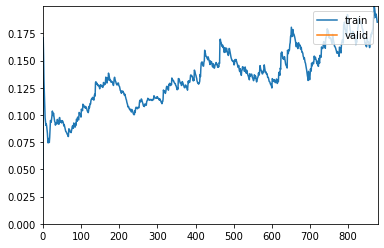

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.120041,0.074590,0.880769,0.887728,0.871795,0.879690,0.952597,03:57
1,0.125028,0.171015,0.803846,0.773672,0.858974,0.814095,0.872991,03:57
2,0.105527,0.087765,0.864103,0.860406,0.869231,0.864796,0.942883,03:56
3,0.097957,0.076767,0.864103,0.908046,0.810256,0.856369,0.949918,03:56
4,0.099394,0.084140,0.858974,0.900000,0.807692,0.851351,0.942709,03:55
5,0.095853,0.077788,0.871795,0.887701,0.851282,0.869110,0.949241,03:54


Better model found at epoch 0 with f1_score value: 0.8796895213454076.


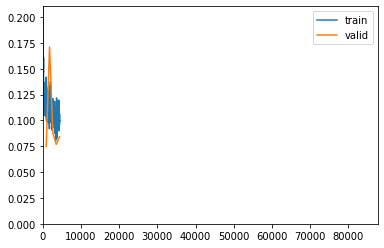

No improvement since epoch 0: early stopping


In [37]:
learn.fine_tune(100,base_lr=3e-3)

In [38]:
dfTest = pd.read_csv('../testSample.csv')

In [39]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [40]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [41]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [42]:
learn.dls = dlsTest

In [43]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9513940828402367.


(#6) [0.09123686701059341,0.892307698726654,0.8828828828828829,0.9046153846153846,0.8936170212765958,0.9513940828402367]